In [1]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 11px;
}
.dataframe td {
    font-size: 11px;
}
</style>

# Unsupervised ML

Unsupervised machine learning is useful when we have **unlabelled** data. This means we have *only input data* and *no output data*. Yet, while we are not predicting labels or values for outcome variables (because we have none!), we can still learn a lot about our data (and, hopefully, the world) by finding patterns in the input data we do have.

The two broad kinds of unsupervised ML are cluserting algorithms and dimensionality reduction algorithms. We'll focus on clustering algorithms, where we aim to partition our observations into clusters based on similarities between them, measured in terms of their attributes. If you continue in data science, you'll also come across dimensionality reduction, which is a technique for reducing *high-dimensional data* (i.e., data with many, many attribute variables) into fewer dimensions that still capture the variation between our variables. This can be useful when our models perform worse on high-dimensional data, as we previewed briefly in the previous section.

For now, we will focus on clustering algorithms. An example clustering tasks might be to group individual animals into different species based on various features, like height, weight, number of offspring, location, and so on. In this case, the researcher does not know what the species are, or even how many there are, but they want to explore the data to look for clusters that might be meaningful to distinguish between these animals based on the known attributes in the data. Note that generally the computer will be able to identify which observations belong to which cluster based on how similar or different they are in terms of their attributes, but it is up to the researcher to decide (a) how many clusters to look for, (b) if those clusters are *useful*, as well as (c) what those clusters might represent in real life.

As another example: a company might use a clustering algorithm to group customers by purchasing behavior. Perhaps they have data on each customer's number of visits to the company website, visits to their various social media accounts, how many times they've opened emails from the company, and the frequency and quantity of purchases in the last year. The company could build a clustering algorithm to partition customers by their values on these attributes. Suppose they looked for and the computer identified three clusters -- someone from the company then might decide those customer groups reflect "regular customers", "persuadable customers", and "one-time only" customers -- or something. Again, the researcher ascribes *meaning* to the clusters -- the computer just finds out where they are based on how similar or different each observation is. All the computer is going to tell us is which observations belong to cluster 0, 1, or 2 -- and the computer of course is doing so based on the instructions we provide for finding the clusters.

Let's make this more concrete by considering a common clustering algorithm, $k$-means.

## Clustering algorithm: $k$-means

The core idea in $k$-means is that observations of the same class will be clustered together in what we call the **feature space**, which simply refers to the spatial representation of our observations in terms of their values. A simple scatter plot of two attributes (say, height and weight of each animal) is an example of a 2D feature space. If we had three variables (say, we add number of offspring), we would have a three-dimensional scatterplot and thus a 3D feature space. As discussed in the previous section, it quickly becomes difficult to visualize 4, 5, and n-dimensional feature spaces, but luckily for us, computers are great at doing the calculations to find the distances between variables in multi-dimensional feature space.

The core assumption, thus, is that differences in the features of our observations (e.g., the height, weight, and offspring numbers) are representative of different classes or categories of those observations (i.e., different species). Note that this is an *assumption* and is not guaranteed. I may have a principled, theoretical reason to expect that there are three species in my dataset, and that the values for the attributes for which I have data are different in ways that reflect these three species, but I do not know for sure whether that's true.

### Steps in the algorithm

The $k$-means clustering algorithm proceeds according to the following high-level steps, which are also depicted in the visualization below. Suppose we have an unlabelled dataset in which we hope to discover some underlying structure. Then:

1. We (humans) choose the number of clusters to look for, $k$
2. The algorithm selects $k$ random points and assigns them as centroids.
3. Assign each data point to the closest centroid (often calculated by Euclidean distance, just as we saw with $k$-NN)
4. Compute the centroid of the newly-formed cluster
5. Repeat steps 3-4 until the centroid location is stable.

:::{figure-md} k_means
<img src="images/k_means.png" alt="k_means" class="bg-white mb-1" width="1000px">

Visualization of the five steps in $k$-means
:::

Unsupervised techniques don't generally use a training and test set because we don't have any labels against which to test our predictions. Evaluation of $k$-means thus generally is done based first by theory: Do these clusters make sense given my knowledge and expectations of the underlying data? Second, because $k$-means is based on the random placement of our initial $k$ centroids, running the same model over and over (with different random states!) and ending up with the same, or at least roughly the same, clusters over and over and also help increase our confidence that these clusters are at least robust, or informative of *something* in the data. Again, the actual meaning, or even label we might assign to the clusters, is up to us.

Aside: $k$-means (and other clustering techniques) can feel unsatisfying to newcomers to unsupervised learning, as it can feel like we are just squinting our eyes at a scatterplot and trying to derive meaning, tea-leaves style. To some extent there is some interpretation -- we ultimately decide if these clusters are *useful* to us as we attempt to understand our world, but there's a little more behind the clusters themselves than tea leaves, as the clusters are based on actual distances in the feature space. That said, "unsupervised machine learning clustering algorithm" sounds *extremely* high-tech, when really what we are doing, in the wise words of a former DS4E professor, Sarah Shugars, boils down to "fancy counting."

## Example

To keep things simple, we'll yet again turn to our trusty horses dataset to build some further intuition for how $k$-means works, as well as implement it in python. Unlike with supervised ML, we're going to cut right to the "canned" version from our friends at `sklearn`. Thus, first, we'll need a few new packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## new packages for k-means ##
from sklearn.preprocessing import StandardScaler       # for feature scaling
from sklearn.cluster import KMeans                     # our kmeans algorithm
from sklearn import metrics                            # for evaluation metrics

horses = pd.read_csv('data/horses.csv')
horses.head(2)

name   price      sex  height     color  \
0           Captain  5000.0  Gelding  14.212       Dun   
1  Eternal Goodness  8500.0  Gelding  16.205  Chestnut   

                   location markings weight foaldate  \
0  Nantucket, Massachusetts      NaN    NaN    4-May   
1     Brooklyn, Connecticut      NaN    NaN    3-May   

                                registrations  \
0  Norwegian Fjord Horse Registry (04-6018-G)   
1                         JC - Jockey Club ()   

                                         disciplines  temperament  
0  Beginner/Family  Cowboy Mounted Shooting  Trai...        1.005  
1  Jumper (Competed or Shown) Hunter (Competed or...        1.010

Recall that three of our variables are numeric: `price`, `height`, and `temperament`. We'll use all three for our $k$-means clustering algorithm, meaning python will look for clusters in the 3D feature space. 

But first, let's plot height vs. temperament to get a feel for things. Notice this is not the most beautiful data in the world (though I think we can all agree it is the most fascinating!), but it will do for our illustrative purposes.

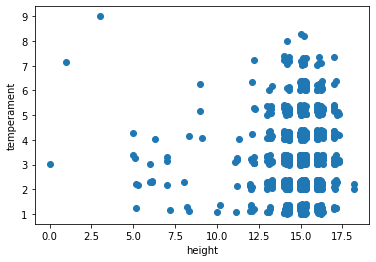

In [3]:
plt.scatter(horses['height'], horses['temperament'])
plt.xlabel('height')
plt.ylabel('temperament')
plt.show()

Eventually, we are going to project our clusters (calculated from three dimensions) onto this particular 2D scatterplot. To get there, we set up for $k$-means much like we did for $k$-NN.

In [4]:
X = horses[['temperament', 'height', 'price']].values     # indicate our three features for analysis

scaler = StandardScaler()                                 # standardize our features (Z-scores FTW!)
scaled_features = scaler.fit_transform(X)

In [5]:
# initialize k-means, set k=3, set random state for replicability

kmeans = KMeans(init='random', n_clusters=3, n_init=10, max_iter=300, random_state=44)

# run k-means!

kmeans.fit(scaled_features)                                             

KMeans(init='random', n_clusters=3, random_state=44)

And ... we did it! We assigned every observation to one of three clusters. But ... how can we see what those clusters are? One way is to add the newly assigned labels as a new variable to our dataframe:

In [6]:
horses['cluster'] = kmeans.labels_          # add a variable called "cluster" that contains the k-means labels
horses.head()

name    price      sex  height     color  \
0               Captain   5000.0  Gelding  14.212       Dun   
1      Eternal Goodness   8500.0  Gelding  16.205  Chestnut   
2        Dustys Fly Boy  15000.0  Gelding  15.192    Grulla   
3     A FEDERAL HOLIDAY   8500.0     Mare  14.999      Grey   
4  WIMPYS TRADITIONSTEP  15000.0  Gelding  14.999  Palomino   

                   location                             markings       weight  \
0  Nantucket, Massachusetts                                  NaN          NaN   
1     Brooklyn, Connecticut                                  NaN          NaN   
2             Dallas, Texas                                  NaN  1200 pounds   
3            HOLSTEIN, Iowa  star, strip, & snip. 3 white socks.          NaN   
4          HOWELL, Michigan                                  NaN  1000 pounds   

  foaldate                                      registrations  \
0    4-May         Norwegian Fjord Horse Registry (04-6018-G)   
1    3-May                                JC - Jockey Club ()   
2    6-Apr  AQHA - American Quarter Horse Association (484...   
3    5-Apr       AQHA - American Quarter Horse Association ()   
4    9-Apr  AQHA - American Quarter Horse Association (526...   

                                         disciplines  temperament  cluster  
0  Beginner/Family  Cowboy Mounted Shooting  Trai...        1.005        2  
1  Jumper (Competed or Shown) Hunter (Competed or...        1.010        2  
2  Beginner/Family (Champion) Youth/4-H Horse (Ch...        1.012        2  
3  Western Pleasure (Show) (Competed or Shown) Yo...        1.013        2  
4  Youth/4-H Horse (Trained) Ranch Horse (Trained...        1.013        2

If you look to the last variable, you'll see we now have cluster numbers assigned to each variable. To see which observation ended up in which cluster, we go back to our original 2D scatterplot (which, again, will project the clusters calculated based on three dimensions).

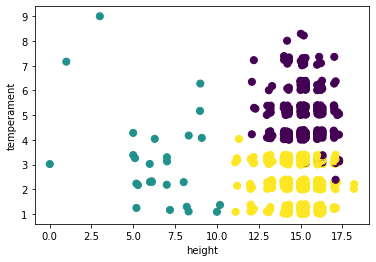

In [7]:
ax = plt.figure(figsize=(6,4)).add_subplot(111)
ax.scatter(horses['height'], 
           horses['temperament'],  
           c = horses['cluster'], s=50);
ax.set_xlabel("height")
ax.set_ylabel("temperament");

Ta da! We did it! We have partitioned our observations into three clusters. You can also run this many times and see for yourself that the clusters are relatively stable over time. 

So, have we learned anything about some underlying structure or pattern in the data? Well, it's hard to say. We can observe the following about the clusters so far:

- **yellow**: these horses are taller and calmer (lower temperament score = more calm)
- **purple**: these horses are about the same height as the horses in the yellow cluster, but they are less calm, or more "hot"
- **green**: the horses in this cluster are all shorter than the other two clusters, and they have a range of temperaments

It's up to us, the researchers, to decide if those clusters "mean" anything in the real world. This is one big area where substantive expertise matters -- if you're reading this book and you know a lot about horses, you may be shouting some particular names or descriptors that might map well to these clusters (feel free to let us know what they are!).

Recall also we are plotting clusters based on three dimensions (height, temperament, price) on a 2D scatterplot. Thus, the cluster assignments may be picking up price differences in the horses as well.

Let's project our clusters onto a *different* 2D scatter to see if any other helpful patterns arise in terms of what these clusters might represent in real life.

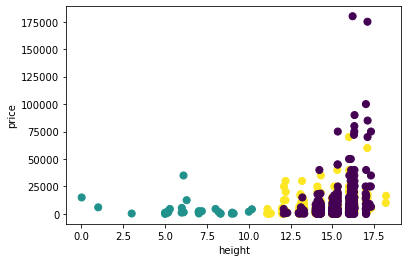

In [8]:
ax = plt.figure(figsize=(6,4)).add_subplot(111)
ax.scatter(horses['height'], 
           horses['price'],  
           c = horses['cluster'], s=50);
ax.set_xlabel("height")
ax.set_ylabel("price");

Here see the same information in a slightly different format: height does not seem to be a big factor in distinguishing yellow from purple horses, and neither does price. The distinction in this cluster really does seem to be driven by temperament.

Finally, we can also inspect all three dimensions in a 3D scatterplot as we did with *k*-NN.

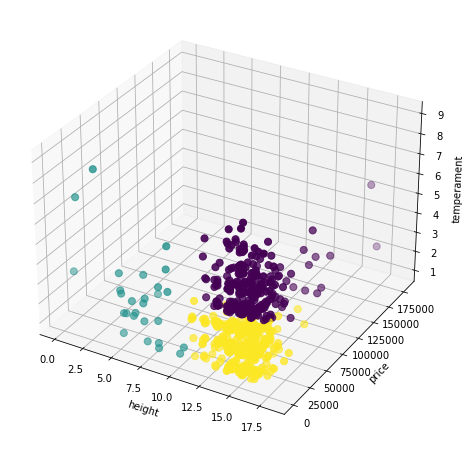

In [9]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(horses['height'], 
           horses['price'], 
           horses['temperament'], 
           c = horses['cluster'], s=50);
ax.set_xlabel("height")
ax.set_ylabel("price")
ax.set_zlabel("temperament");

In the above plot, we can see that:

- **yellow** horses are tall and calm, but not as expensive as purple ones
- **purple** horses are slightly less tall than yellow ones, but more expensive and less calm
- **green** horses are, indeed, shorter and mostly (though not entirely) less expensive than the other two clusters, and appear to have something of a range of temperaments

A (perhaps) reasonable "interpretation" of these clusters, then, might be that given their price and temperament, **purple** horses might be racehorses, **yellow** horses might be horses used in other types of competitions, and **green** horses might be more recreational or kid-friendly horses.

Again, this application of "meaning" comes from us, the researchers. What do you think the clusters represent?

Because we are working with three features, we can visualize the full picture. If we had four, five, or many more features, we would not be able to visualize the full picture at once; rather, we'd have to continue to inspect partial views on 2D and 3D plots.

In addition, notice that we've only explored $k=3$. We encourage you to try other values for $k$. Which one do you think best captures the variation in the data?